# Insurance Charges Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

## Dataset Summary

In [2]:
idf = pd.read_csv('insurance.csv')
idf.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
idf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### From the above tables:
- We can see that there are total 1338 rows or examples in the dataset and each instance has 7 columns or features. - Out of the 7 features, the features "sex", "smoker" and "region" are of type object, i.e. categorical attributes.
- Rest all the features are continuous valued feature of type integer/float. <br>

        Thus, we can say that we have total 4 continuous valued attributes and 3 categorical attributes.


In [4]:
idf.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


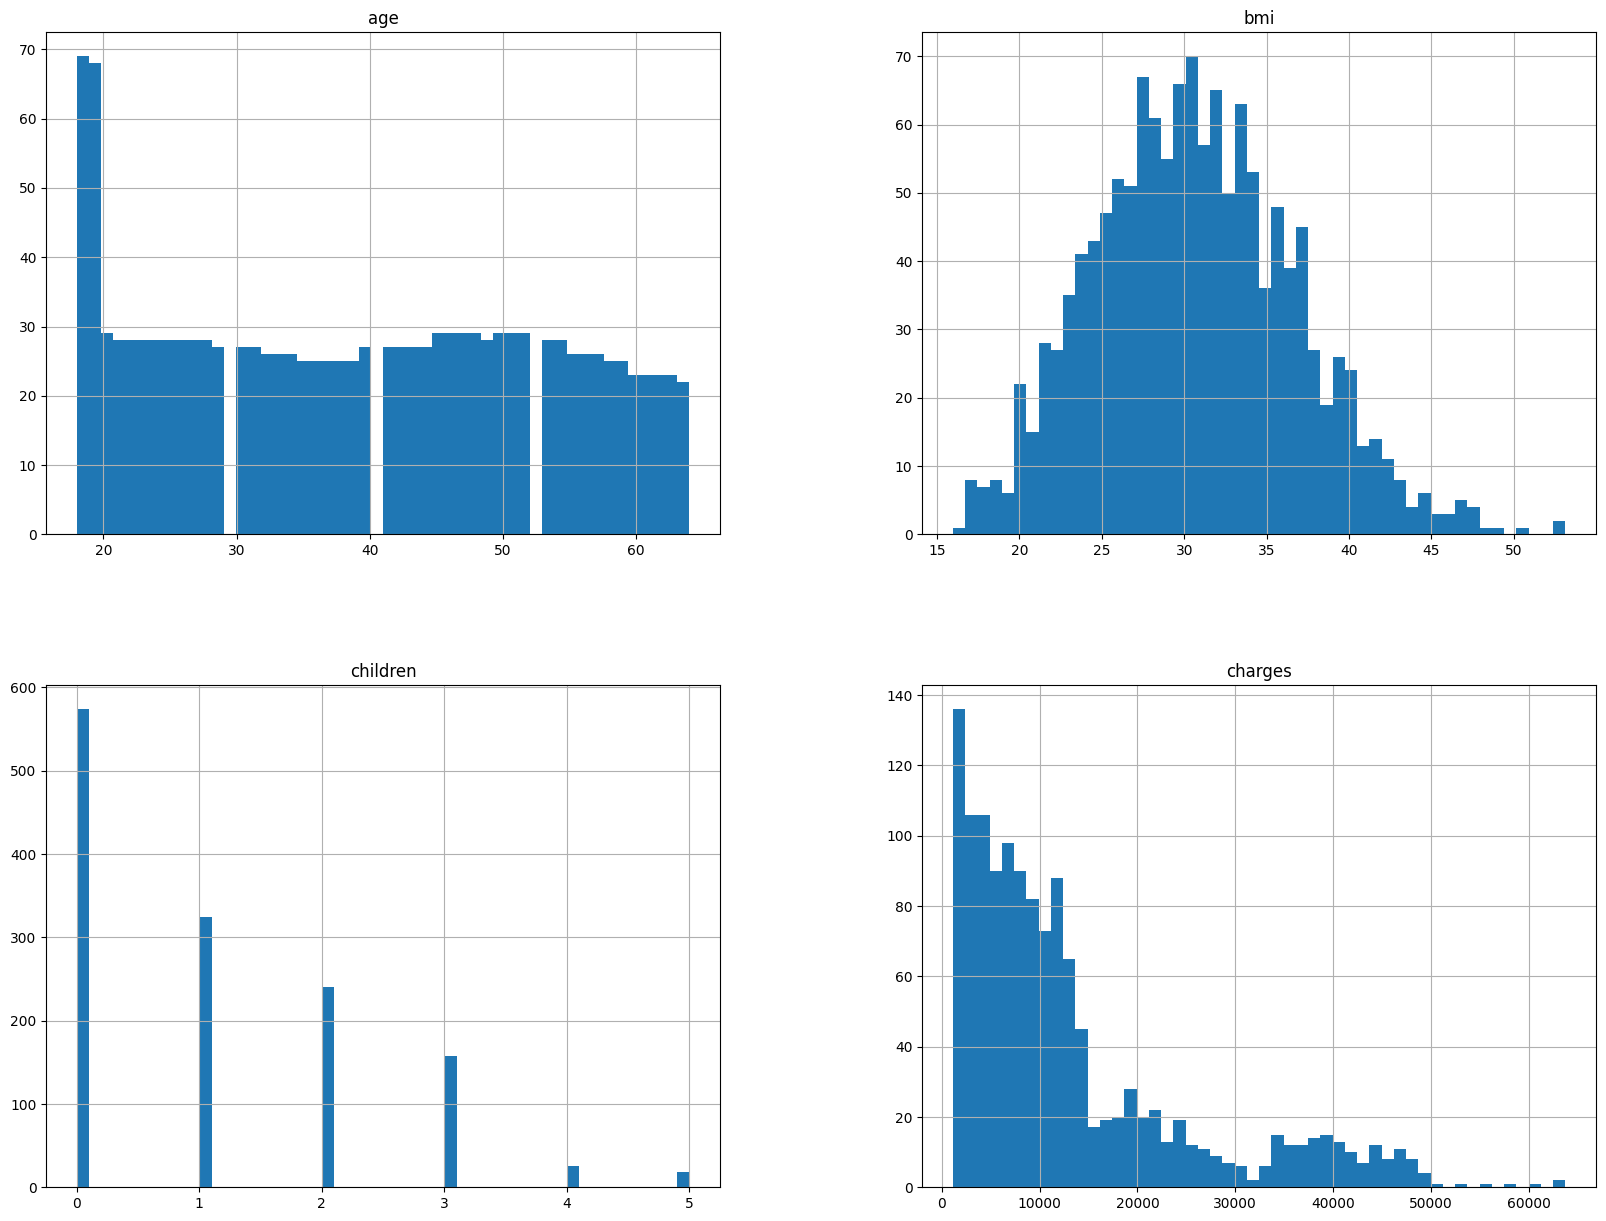

In [5]:
%matplotlib inline
idf.hist(bins=50, figsize=(20,15))
plt.show()

The statistical value, showing the mean, standard deviation, minimum, maximum, 1st quartile, 2nd quartile, median and 3rd quartile of each numerical attribute, is displayed in the above cells along with the histogram of the distribution of those attributes. <br>

From the statistical values, 
 - We can infer that the feature "age" has maximum deviation from it's mean value as compared to other attributes.
 - Also, none of the features seem to be scaled.

From the graph,
- We can see that most of the features(except bmi) extend much farther to the left of the median than to the right, i.e. they are head-heavy.

Attribute Treatments:
- None of the features have null or missing values, so we don't need to worry about replacing or removing bad values.
- All the attributes might need to be scaled so that all the attributes are on same scale which will improve the model's convergence speed and avoid any undesirable effects when using SGD regression. We'll do standard scaling of all features so that they have 0 mean and unit variance.

## Feature Selection

In [6]:
# Correlation between data attributes
idf.corr(numeric_only=1)

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [7]:
# Pearson Correlation Coefficient (PCC) matrix
corr_df = idf.corr(numeric_only=1)
corr_df['charges'].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

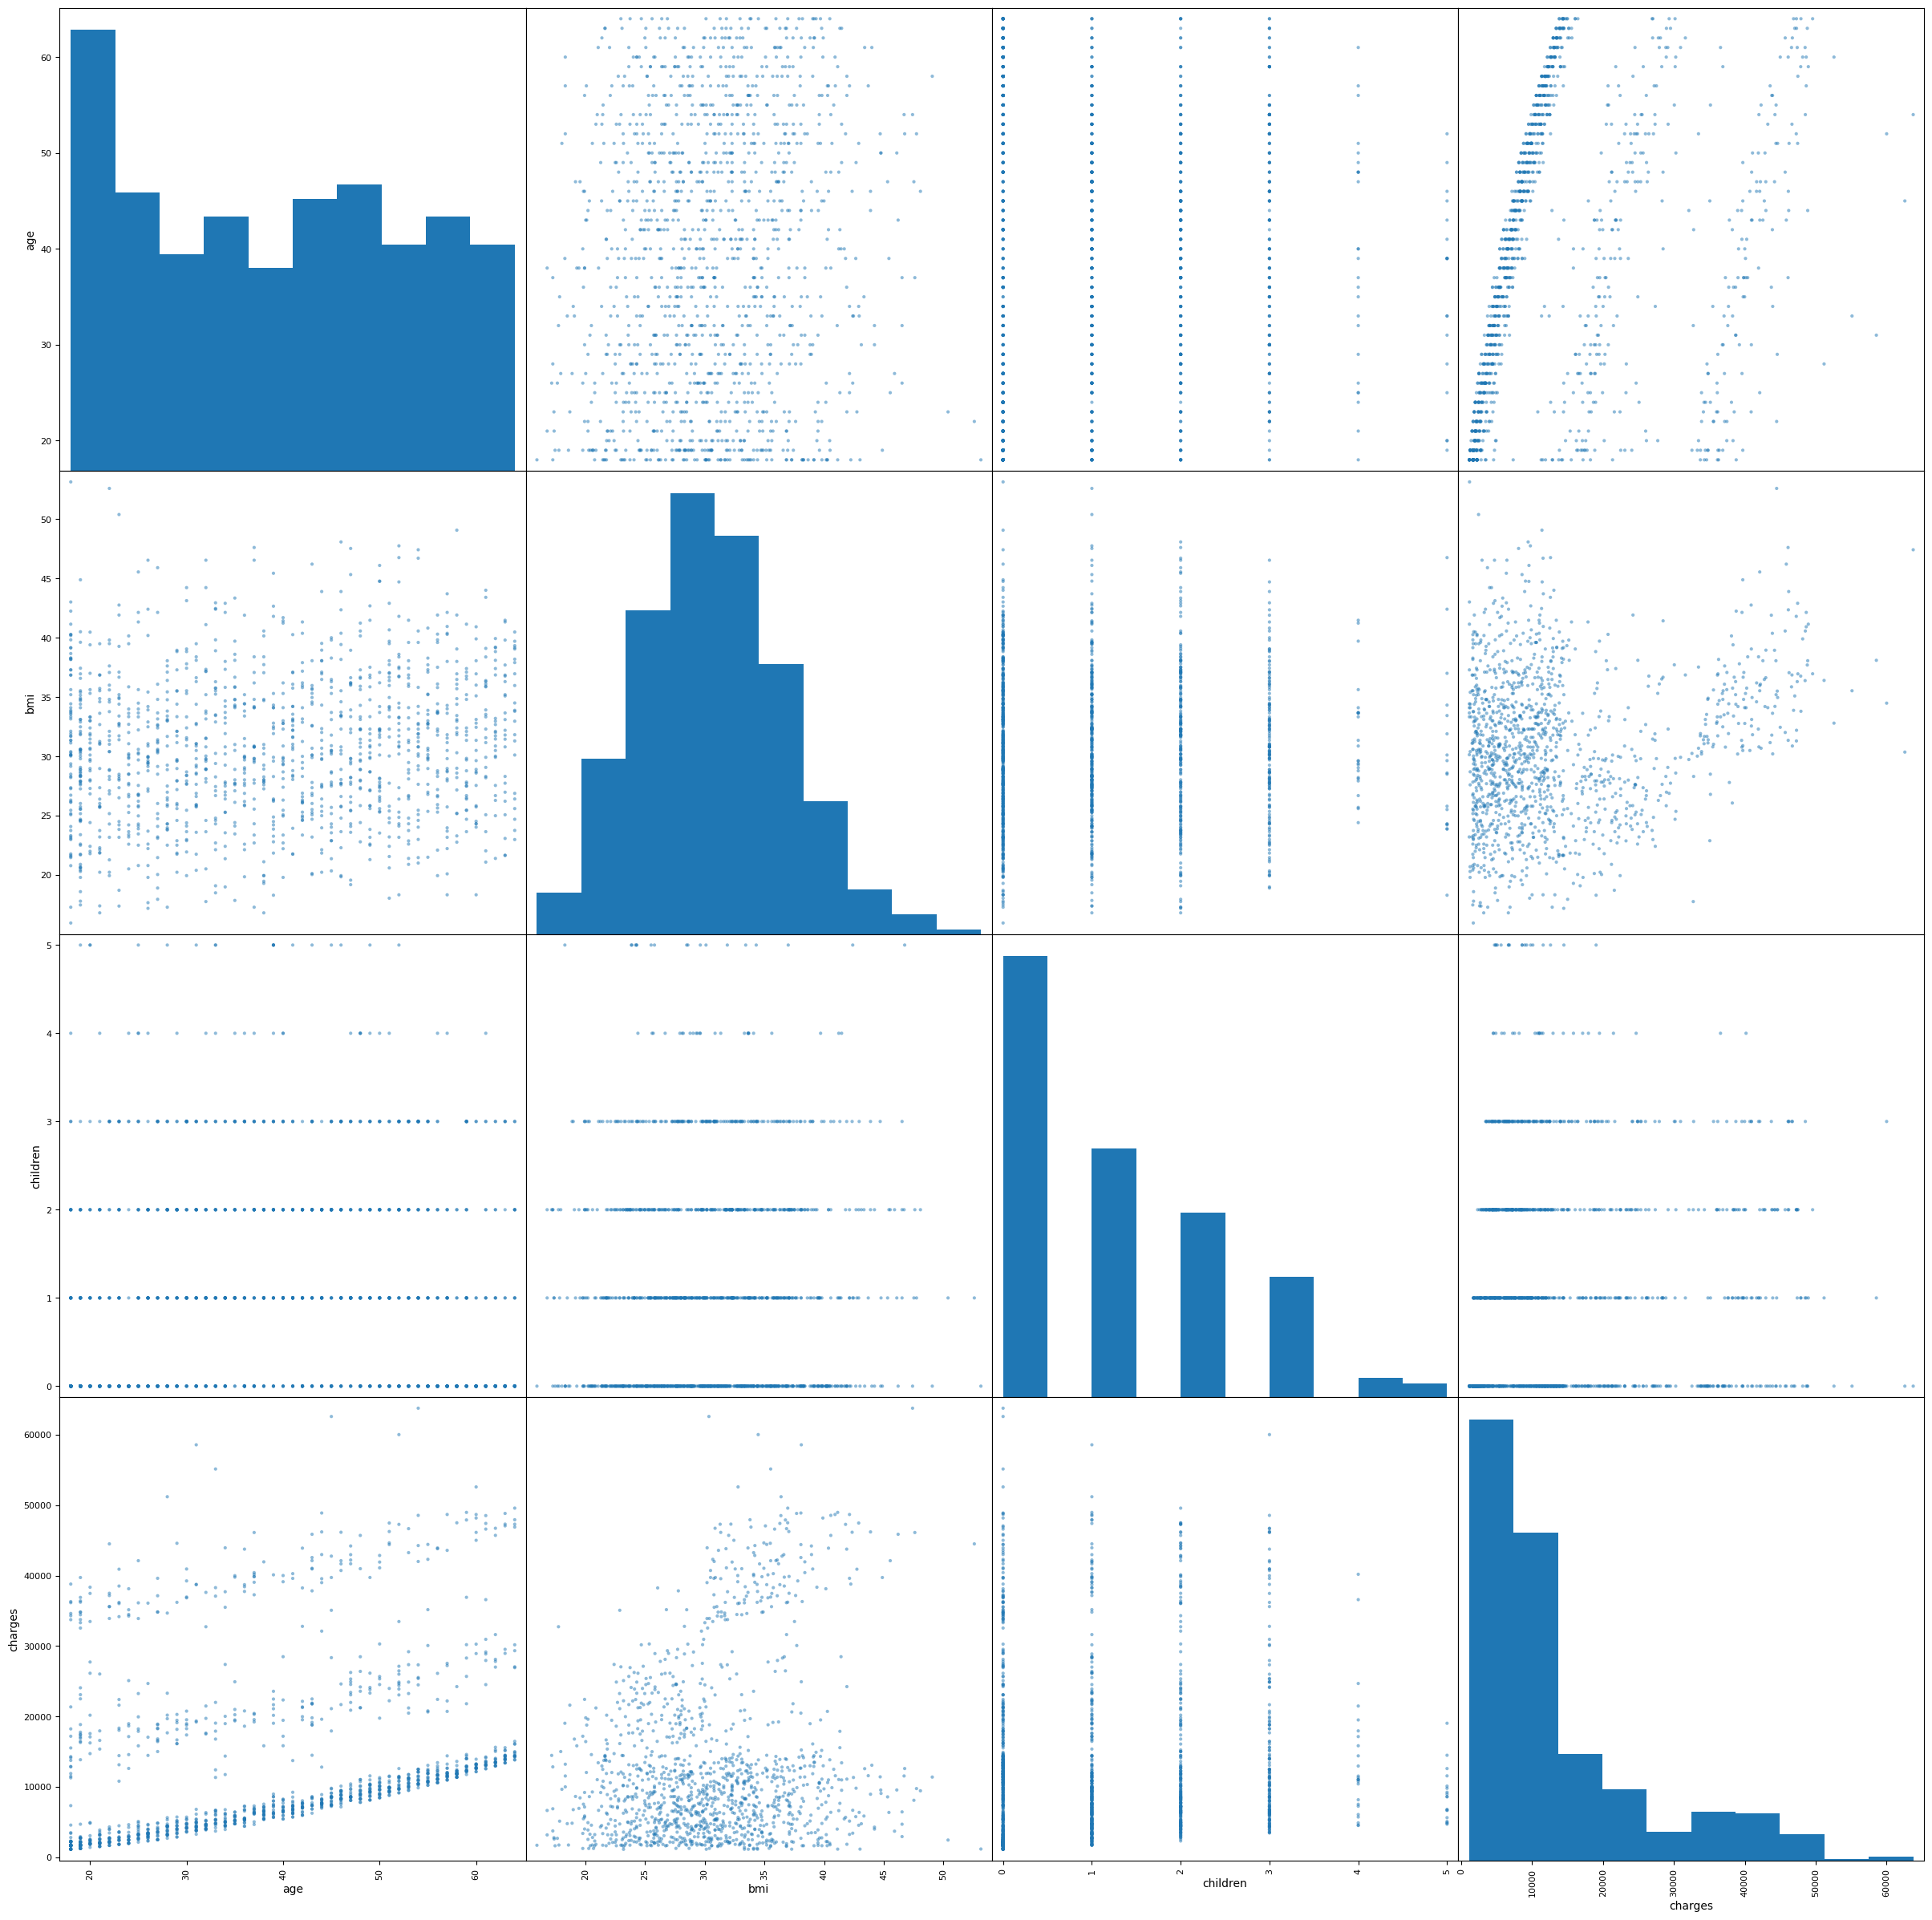

In [8]:
# Scatter plots
scatter_matrix(idf, figsize=(30,30))
plt.show()

- From the correlation matrix and scatter plots, we can see that the target 'charges' does not have any strong correlation with any of the features.
- Also, there does not appear any good correlation among the features as all the correlation coefficients are less than 0.3 indicating that there is a very little(or no) linear correlation between the attributes.

## Preparing Train and Test sets

In [9]:
idf["age category"] = pd.cut(idf["age"], bins=[0, 19, 30, 45, 57, np.inf], labels=[1,2,3,4,5])

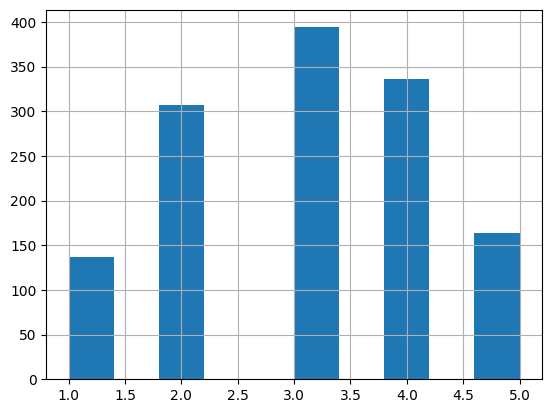

In [10]:
idf["age category"].hist()
plt.show()

### To make sure that the test set is representative of the entire dataset, we divide the dataset into homogenous subgroups of different age groups as we can see from the above histograms that this feature can be easily divided into few strata with each of them having enough instances to sample from.

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=33)
for train_index, test_index in split.split(idf, idf['age category']):
    train_set = idf.loc[train_index]
    test_set = idf.loc[test_index]

In [12]:
print("Test Set - age category proportions")
test_set["age category"].value_counts() / len(test_set)

Test Set - age category proportions


3    0.294776
4    0.250000
2    0.231343
5    0.123134
1    0.100746
Name: age category, dtype: float64

In [13]:
print("Full DataSet - age category proportions")
idf["age category"].value_counts()/ len(idf["age category"])

Full DataSet - age category proportions


3    0.294469
4    0.251121
2    0.229447
5    0.122571
1    0.102392
Name: age category, dtype: float64

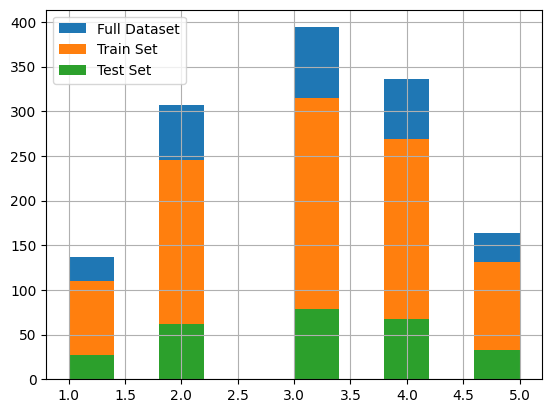

In [14]:
ax1 = idf['age category'].hist(label='Full Dataset')
train_set['age category'].hist(label='Train Set')
test_set['age category'].hist(label='Test Set')
plt.legend()
plt.show()

### From the above histogram and the proportions observed, we can infer that the test set has "age category" proportions almost identical to those in the full dataset. Thus, it is verified that the test portion of the data is representative of the entire dataset.

In [15]:
# Dropping the 'age category' column
for set in (train_set, test_set):
    set.drop(columns='age category', inplace=True)

In [16]:
# Feature scaling and Ordinal encoding of categorical attributes
full_pipeline = ColumnTransformer([
    ('categoricalEncoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['sex', 'smoker', 'region']),
    ('scaling', StandardScaler(), ['age', 'bmi', 'children', ]),
    ('targetscaling', StandardScaler(), ['charges'])
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

train = full_pipeline.fit_transform(train_set)
test = full_pipeline.transform(test_set)

In [17]:
# Separating input features and target in both training and testing sets
train_x = train.drop(columns='charges')
train_y = train['charges'].copy()
test_x = test.drop(columns='charges')
test_y = test['charges'].copy()

## Linear Regression using hyperparameter tuning and cross-validation

### Closed form solution using Normal Equation

In [18]:
# Adding x0 = 1 to each instance of both training and testing sets
# This will be used only with Normal Equation
train_x_b = np.c_[np.ones(train_x.shape[0]), train_x]
test_x_b = np.c_[np.ones(test_x.shape[0]), test_x]

# Computing the model parameters using Normal Equation
theta_best = np.linalg.inv(train_x_b.T.dot(train_x_b)).dot(train_x_b.T).dot(train_y)
theta_best

array([-0.34447613, -0.03409757,  1.96463386, -0.03333581,  0.30004406,
        0.15561635,  0.03832178])

In [19]:
# Using scikit-learn (more efficient as compared to above approach as sklearn uses SVD)
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)
lin_reg.intercept_, lin_reg.coef_

(-0.3444761267059695,
 array([-0.03409757,  1.96463386, -0.03333581,  0.30004406,  0.15561635,
         0.03832178]))

- From the above output, we can see that the sklearn library's LinearRegression also computes the model parameters using the Normal Equation.

In [20]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())

    Four-fold cross-validation

In [21]:
lin_scores = cross_val_score(lin_reg, train_x, train_y, scoring='neg_mean_squared_error', cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.45924207 0.50160646 0.47841402 0.48798554]
Mean: 0.481812021997558
Standard Deviation: 0.015418181796330485


### SGD Linear Regression

In [22]:
tr_x, val_x = train_test_split(train_x, test_size=0.1, random_state=33)
tr_y, val_y = train_test_split(train_y, test_size=0.1, random_state=33)

In [23]:
def model_fit(n_epochs, model, tr_x, tr_y, val_x, val_y):
    loss = {'train':[], 'val':[]}
    coeff_sum = []
    iterations = []

    for epoch in range(n_epochs):
        model.partial_fit(tr_x, tr_y)
        train_pred = model.predict(tr_x)
        val_pred = model.predict(val_x)
        
        coeff = np.sum(model.coef_)
        train_loss = mean_squared_error(tr_y, train_pred, squared=False)
        val_loss = mean_squared_error(val_y, val_pred, squared=False)

        coeff_sum.append(coeff)
        loss['train'].append(train_loss)
        loss['val'].append(val_loss)
        iterations.append(epoch+1)
    
    return iterations, coeff_sum, loss

In [24]:
def mini_batch_gd(n_epochs, model, tr_x, tr_y, val_x, val_y, batch_size):
    loss = {'train':[], 'val':[]}
    iterations = []

    for epoch in range(n_epochs):
        start = 0
        tx, ty = tr_x, tr_y
        while start < len(tr_x):
            end = (start + batch_size )if ((start + batch_size) < len(tx)) else len(tx)-1
            model.partial_fit(tx[start:end], ty[start:end])
            start += batch_size

        train_pred = model.predict(tr_x)
        val_pred = model.predict(val_x)
        
        train_loss = mean_squared_error(tr_y, train_pred, squared=False)
        val_loss = mean_squared_error(val_y, val_pred, squared=False)

        loss['train'].append(train_loss)
        loss['val'].append(val_loss)
        iterations.append(epoch+1)
    return iterations, loss

In [25]:
def train_loop(title, n_epochs=100, penalty='l2', learning_rate='invscaling'):
    penalty_terms = [1000, 100, 10, 1, 0.1]
    batch_sizes = [5, 100, 400]
    learning_rates = [0.1, 0.01, 0.001, 0.0001]

    fig = plt.figure(figsize=(15,8))
    fig.suptitle(title)

    # Penalty terms and it's impact
    plt.subplot(2,2,1)
    plt.title('penalty_term(alpha) vs coefficients_sum')
    for i in range(len(penalty_terms)):
        alpha = penalty_terms[i]
        sgd_reg = SGDRegressor(penalty=penalty, alpha=alpha, learning_rate=learning_rate, eta0=0.0001)

        iterations, coeff_sum, loss = model_fit(n_epochs, sgd_reg, tr_x, tr_y, val_x, val_y)

        plt.plot(iterations, coeff_sum, label=f'alpha = {alpha}')
        plt.xlabel('Training Iteration')
        plt.ylabel('Sum of Coefficients')
    plt.legend()

    # Batch size and it's impact
    plt.subplot(2,2,2)
    plt.title('batch_size vs loss')
    for batch in batch_sizes:
        sgd_reg = SGDRegressor(penalty=penalty, learning_rate=learning_rate, eta0=0.04)
        iterations, loss = mini_batch_gd(n_epochs, sgd_reg, tr_x, tr_y, val_x, val_y, batch)
        plt.plot(iterations, loss['train'], label=f'batch_size = {batch}')
        plt.xlabel('Training Iteration')
        plt.ylabel('RMSE')
    plt.legend()

    # Learning rate and it's impact
    plt.subplot(2,2,3)
    plt.title('learning rate vs validation loss')
    for i in range(len(learning_rates)):
        lr = learning_rates[i]
        sgd_reg = SGDRegressor(penalty=penalty, learning_rate=learning_rate, eta0=lr)
        iterations, coeff_sum, loss = model_fit(n_epochs, sgd_reg, tr_x, tr_y, val_x, val_y)
        plt.plot(iterations, loss['val'], label=f'learning_rate = {lr}')
        plt.xlabel('Training Iteration')
        plt.ylabel('RMSE')
    plt.legend()

    # Training and Validation Loss as a function of training iterations
    sgd = SGDRegressor(penalty=penalty, learning_rate=learning_rate)
    iterations, coeff_sum, loss = model_fit(n_epochs, sgd, tr_x, tr_y, val_x, val_y)
    plt.subplot(2,2,4)
    plt.plot(iterations, loss['train'], label='Train Loss')
    plt.plot(iterations, loss['val'], label='Validation Loss')
    plt.title(f'Loss vs iteration')
    plt.xlabel('Training Iteration')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return loss

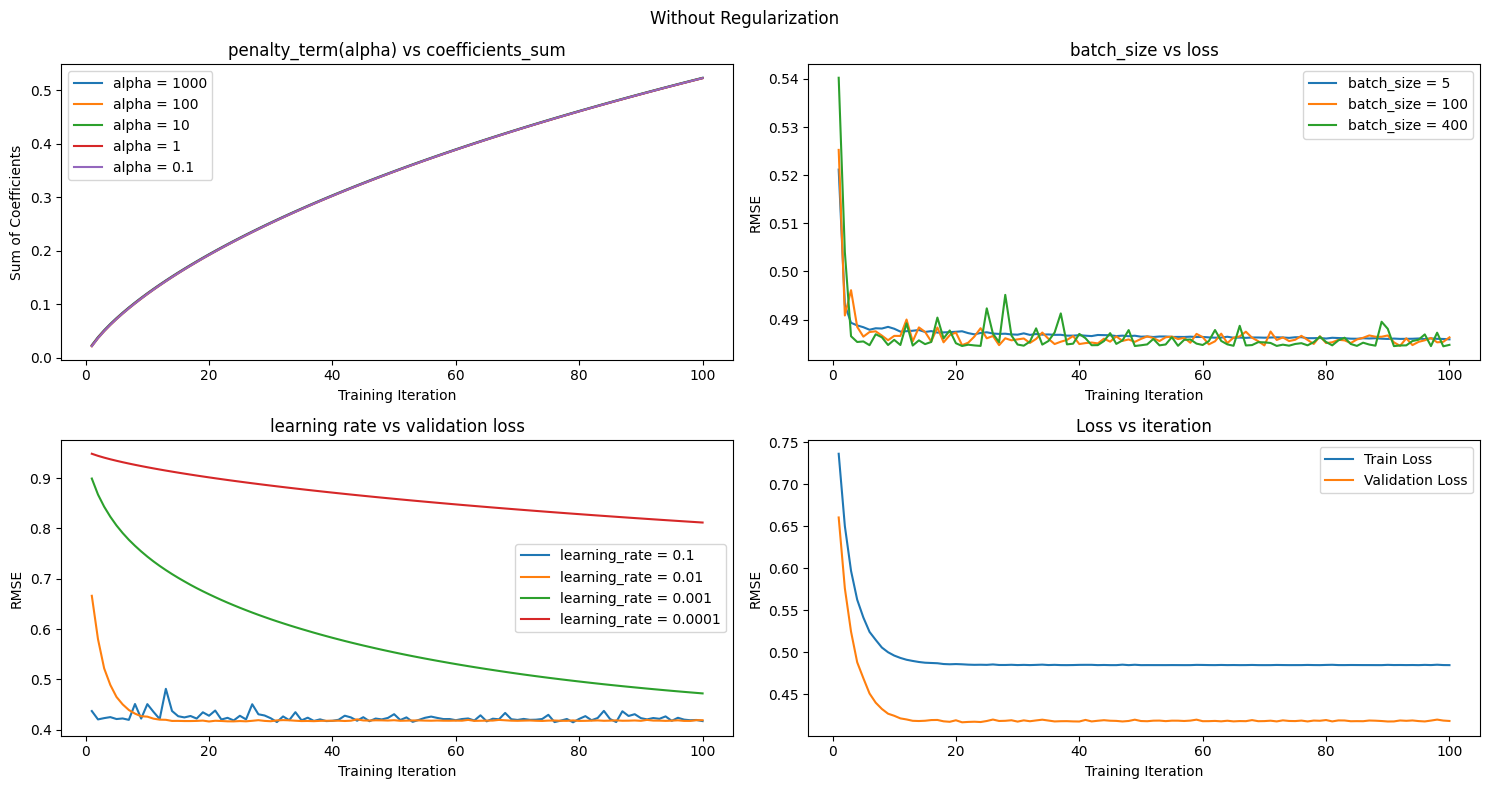

In [26]:
noRegLoss = train_loop(title='Without Regularization', penalty=None)

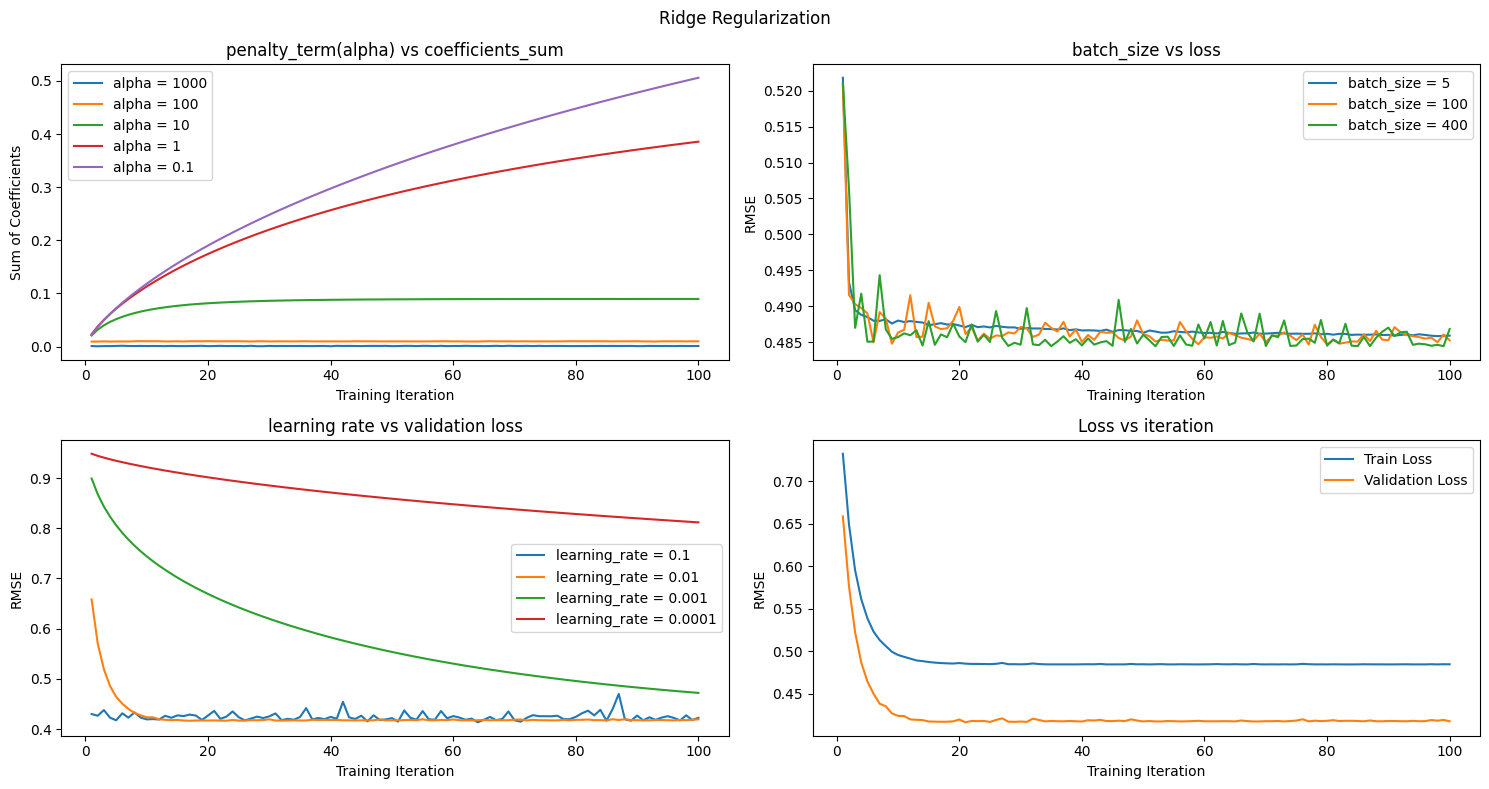

In [27]:
RidgeLoss = train_loop('Ridge Regularization')

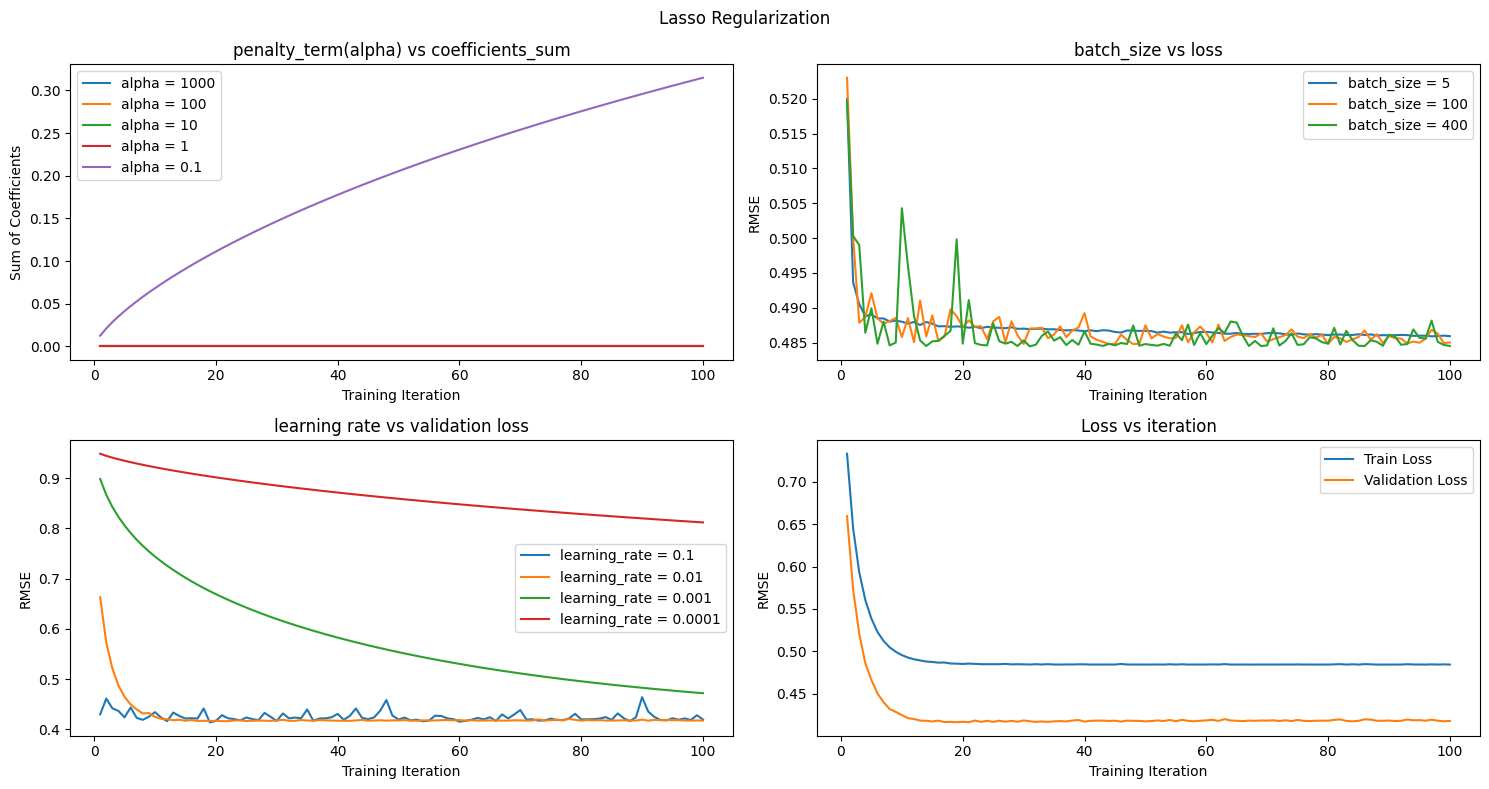

In [28]:
LassoLoss = train_loop('Lasso Regularization', penalty='l1')

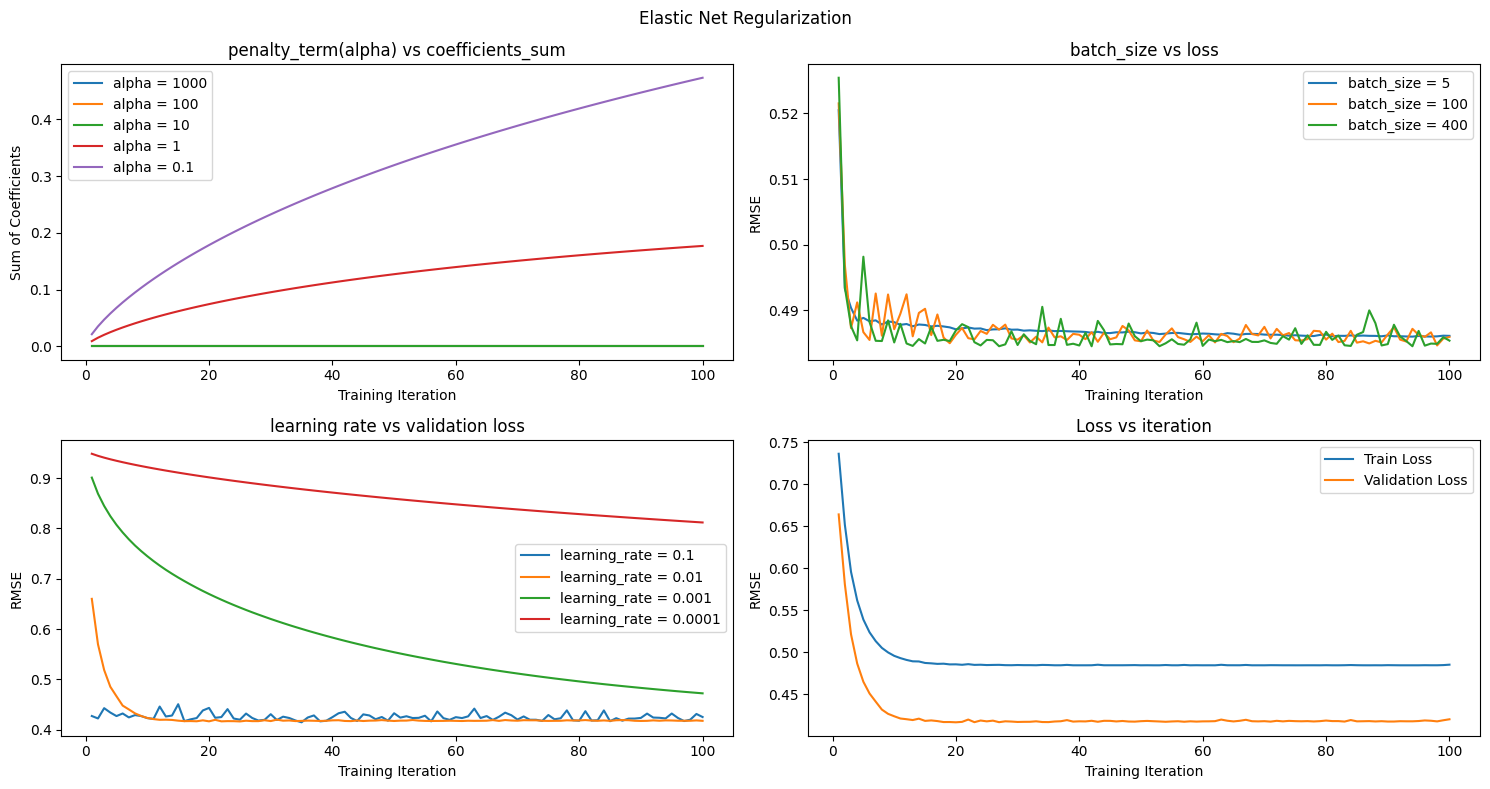

In [29]:
ElasticNetLoss = train_loop('Elastic Net Regularization', penalty='elasticnet')

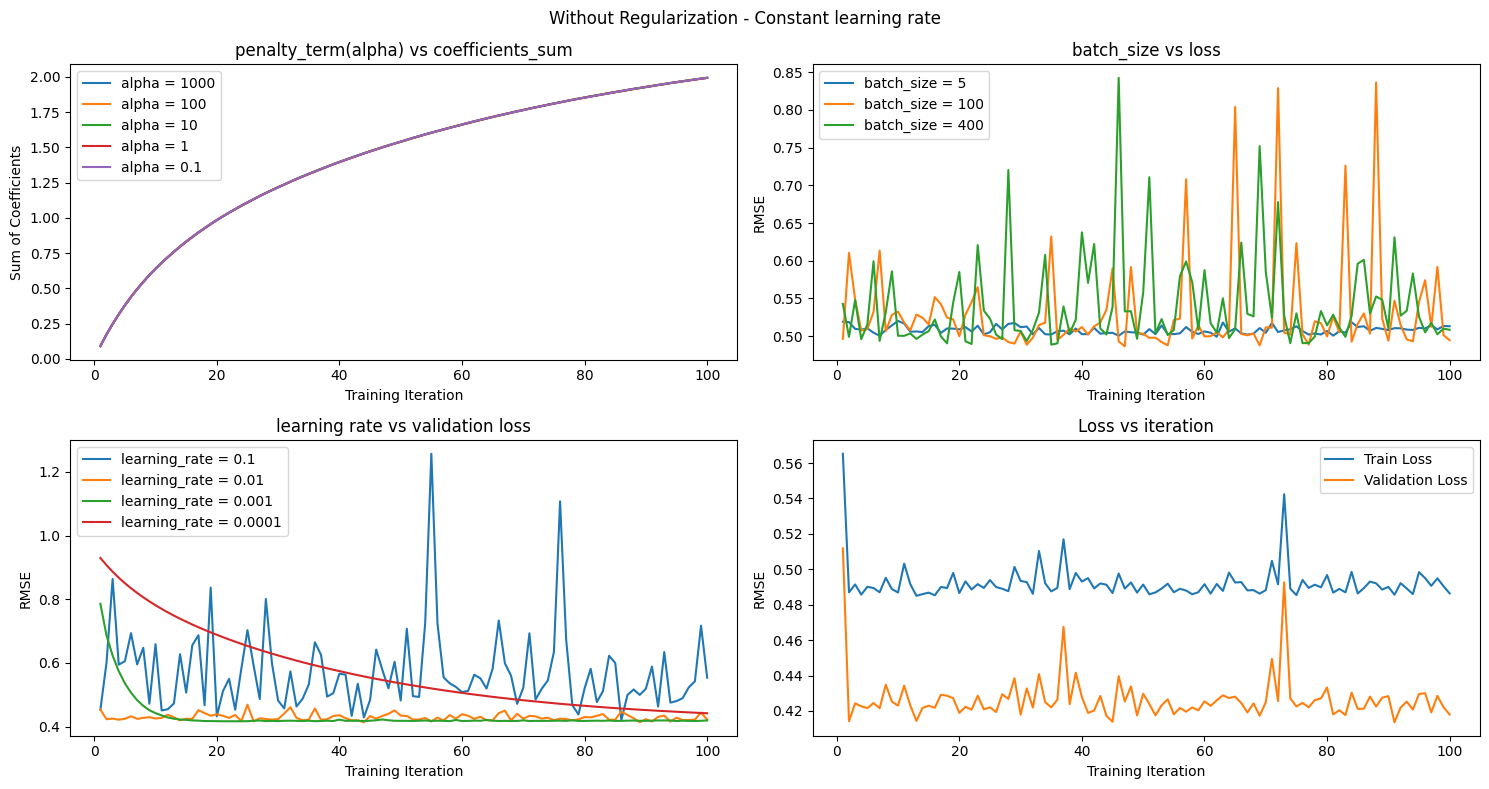

In [30]:
constLearningRate = train_loop(title='Without Regularization - Constant learning rate', penalty=None, learning_rate='constant')

#### Observations:

- The impact of penalty term can be seen from the "penalty_term vs coefficients_sum" graph, where large penalty
terms have stronger regularization of the model coefficients. We can see that for alpha < 1, the sum of coefficients increases with iterations as it imposes less penalty on the coefficients. But for alpha > 1, the coefficients are heavily penalized and thus the coefficients_sum doesn't increase with iterations.

- Mini-Batch GD is particularly useful for cases where the dataset is very huge or the entire dataset can't be fit in the main memory at once. For our case, the dataset is small so the impact of batch_size can't be seen very clearly from the graphs. But, looking at the loss value of different batch sizes against the iterations, we can see that in the long run of incremental learning, all the loss values converge and thus we achieve almost same model parameters with reduced overhead of main memory constraints.

- The learning rate(eta) can decide how fast a model converges, gradient reaches minima to be more precise. Very high learing rate will result in overshooting of minima point and the model coefficients start diverging from the minima instead of converging. In this case, we may never reach the local minima. It can also happen that we keep oscillating around the minima before reaching the minima. <br>
On the other hand, very low learning rate results in very small updates of coefficients at each iteration and requires the training to be done for more number of iterations. From the "learning rate vs validation loss" graphs, we can see that for eta=0.01 reaches low loss earlier than eta=0.001.

## Polynomial regression

In [31]:
# Transforming the training and validation data by adding polynomial features

# remove categorical feature before going polynomial

poly_features = PolynomialFeatures(degree=2, include_bias=False)
train_x_poly =  poly_features.fit_transform(train_x)
tr_x_poly = poly_features.fit_transform(tr_x)
val_x_poly = poly_features.fit_transform(val_x)
test_x_poly = poly_features.transform(test_x)

### Closed form solutions

In [32]:
# Adding x0 = 1 to each instance of both training and testing sets
# This will be used only with Normal Equation
train_x_poly_b = np.c_[np.ones(train_x_poly.shape[0]), train_x_poly]
test_x_poly_b = np.c_[np.ones(test_x_poly.shape[0]), test_x_poly]

# Computing the model parameters using Normal Equation
theta_best_poly = np.linalg.inv(train_x_poly_b.T.dot(train_x_poly_b)).dot(train_x_poly_b.T).dot(train_y)
theta_best_poly

array([ 3.28403419e+15,  7.16737633e+16,  6.06546388e+16, -3.92813916e+00,
        5.67455665e-01,  6.79285771e-01,  8.15848010e-01, -8.03332425e+16,
        2.53594229e+01,  5.43235631e+00, -2.75628364e-01, -2.18755026e-01,
       -3.69576668e-01, -6.04536095e+16,  1.09395852e+01,  5.67715305e-01,
       -2.73533599e+00, -5.62124388e-01, -1.78405083e-01, -2.23582175e-02,
        1.10202711e-01, -1.84522467e-01,  2.86520876e-01,  2.89241382e-01,
        2.23705149e-01,  1.28923296e-01,  1.76912575e-02,  4.72886580e-04])

In [33]:
# Using scikit-learn (more efficient as compared to above approach as sklearn uses SVD)
poly_lin_reg = LinearRegression()
poly_lin_reg.fit(train_x_poly, train_y)
poly_lin_reg.intercept_, poly_lin_reg.coef_

(-0.3453002664072528,
 array([-4.20457666e+11, -6.97120285e+11, -6.14114494e-02,  2.76541907e-01,
         3.79131319e-02,  1.13627555e-01,  4.20457666e+11,  3.28400272e-02,
         1.41318436e-03,  1.71315336e-02,  9.92876140e-04, -1.94508120e-02,
         6.97120285e+11, -5.72534743e-03,  1.03339223e-02,  7.25666457e-01,
        -6.11870123e-02,  8.58073568e-03,  6.85514895e-03, -1.76267938e-02,
        -1.35903600e-02,  5.69894922e-02,  1.30964685e-02, -1.35201478e-03,
        -2.85613892e-02, -3.45583820e-03, -7.27651941e-03]))

In [34]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())

In [35]:
lin_scores = cross_val_score(poly_lin_reg, train_x_poly, train_y, scoring='neg_mean_squared_error', cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.35117804 0.40407138 0.34431198 0.41037493]
Mean: 0.3774840826490915
Standard Deviation: 0.029921100108242754


### SGDRegressor

In [36]:
def poly_train_loop(title, n_epochs=100, penalty='l2', learning_rate='invscaling'):
    penalty_terms = [1000, 100, 10, 1, 0.1]
    batch_sizes = [5, 100, 400]
    learning_rates = [0.01, 0.001, 0.0001]

    fig = plt.figure(figsize=(15,8))
    fig.suptitle(title)

    # Penalty terms and it's impact
    plt.subplot(2,2,1)
    plt.title('penalty_term(alpha) vs coefficients_sum')
    for i in range(len(penalty_terms)):
        alpha = penalty_terms[i]
        sgd_reg = SGDRegressor(penalty=penalty, alpha=alpha, learning_rate=learning_rate, eta0=0.0001)

        iterations, coeff_sum, loss = model_fit(n_epochs, sgd_reg, tr_x_poly, tr_y, val_x_poly, val_y)

        plt.plot(iterations, coeff_sum, label=f'alpha = {alpha}')
        plt.xlabel('Training Iteration')
        plt.ylabel('Sum of Coefficients')
    plt.legend()

    # Batch size and it's impact
    plt.subplot(2,2,2)
    plt.title('batch_size vs loss')
    for batch in batch_sizes:
        sgd_reg = SGDRegressor(penalty=penalty, learning_rate=learning_rate, eta0=0.04)
        iterations, loss = mini_batch_gd(n_epochs, sgd_reg, tr_x_poly, tr_y, val_x_poly, val_y, batch)
        plt.plot(iterations, loss['train'], label=f'batch_size = {batch}')
        plt.xlabel('Training Iteration')
        plt.ylabel('RMSE')
    plt.legend()

    # Learning rate and it's impact
    plt.subplot(2,2,3)
    plt.title('learning rate vs validation loss')
    for i in range(len(learning_rates)):
        lr = learning_rates[i]
        sgd_reg = SGDRegressor(penalty=penalty, learning_rate=learning_rate, eta0=lr)
        iterations, coeff_sum, loss = model_fit(n_epochs, sgd_reg, tr_x_poly, tr_y, val_x_poly, val_y)
        plt.plot(iterations, loss['val'], label=f'learning_rate = {lr}')
        plt.xlabel('Training Iteration')
        plt.ylabel('RMSE')
    plt.legend()

    # Training and Validation Loss as a function of training iterations
    sgd = SGDRegressor(penalty=penalty, learning_rate=learning_rate, eta0=0.001)
    iterations, coeff_sum, loss = model_fit(n_epochs, sgd, tr_x_poly, tr_y, val_x_poly, val_y)
    plt.subplot(2,2,4)
    plt.plot(iterations, loss['train'], label='Train Loss')
    plt.plot(iterations, loss['val'], label='Validation Loss')
    plt.title(f'Loss vs iteration')
    plt.xlabel('Training Iteration')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return loss

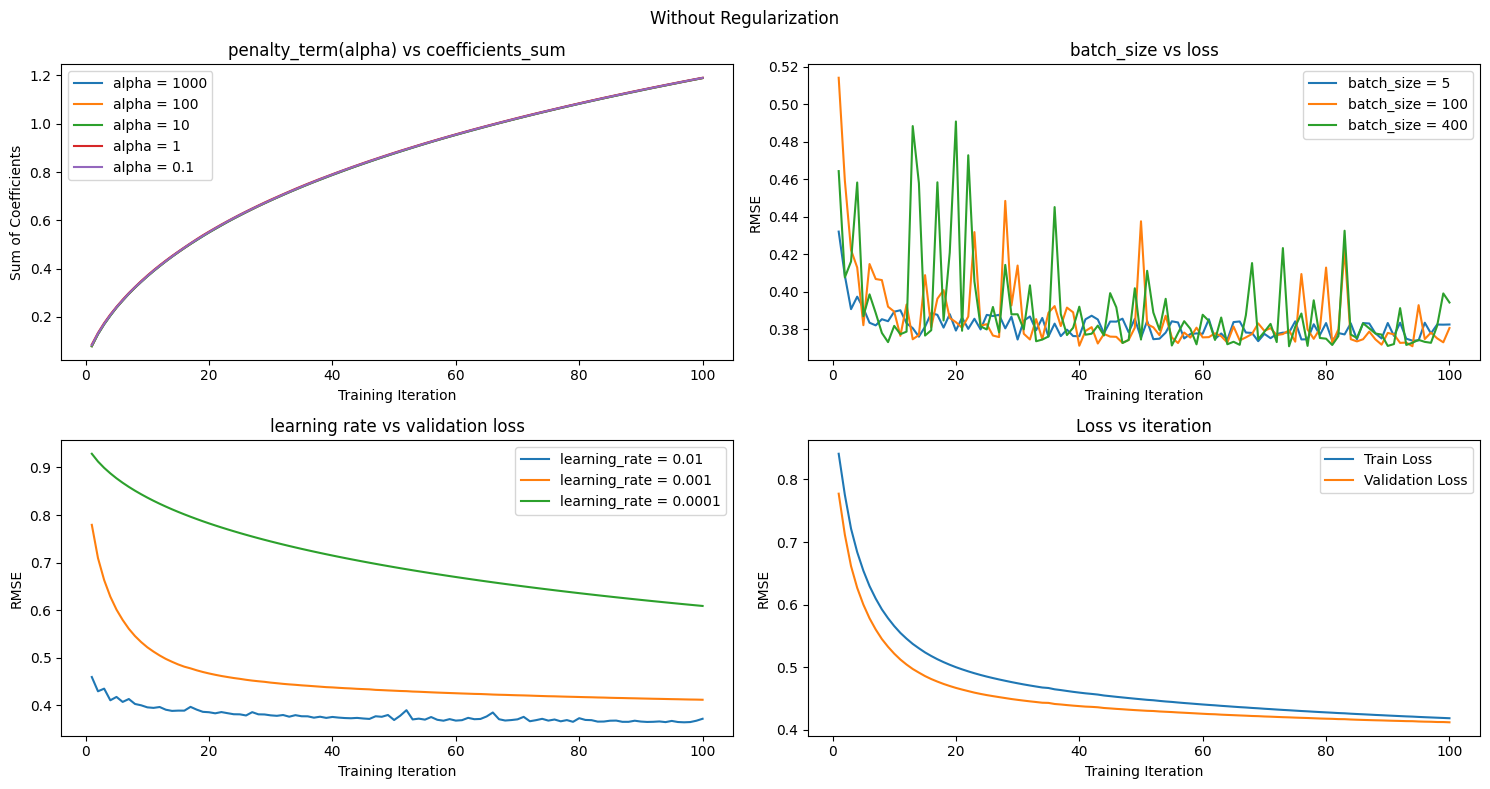

In [37]:
polyNoRegLoss = poly_train_loop(title='Without Regularization', penalty=None)

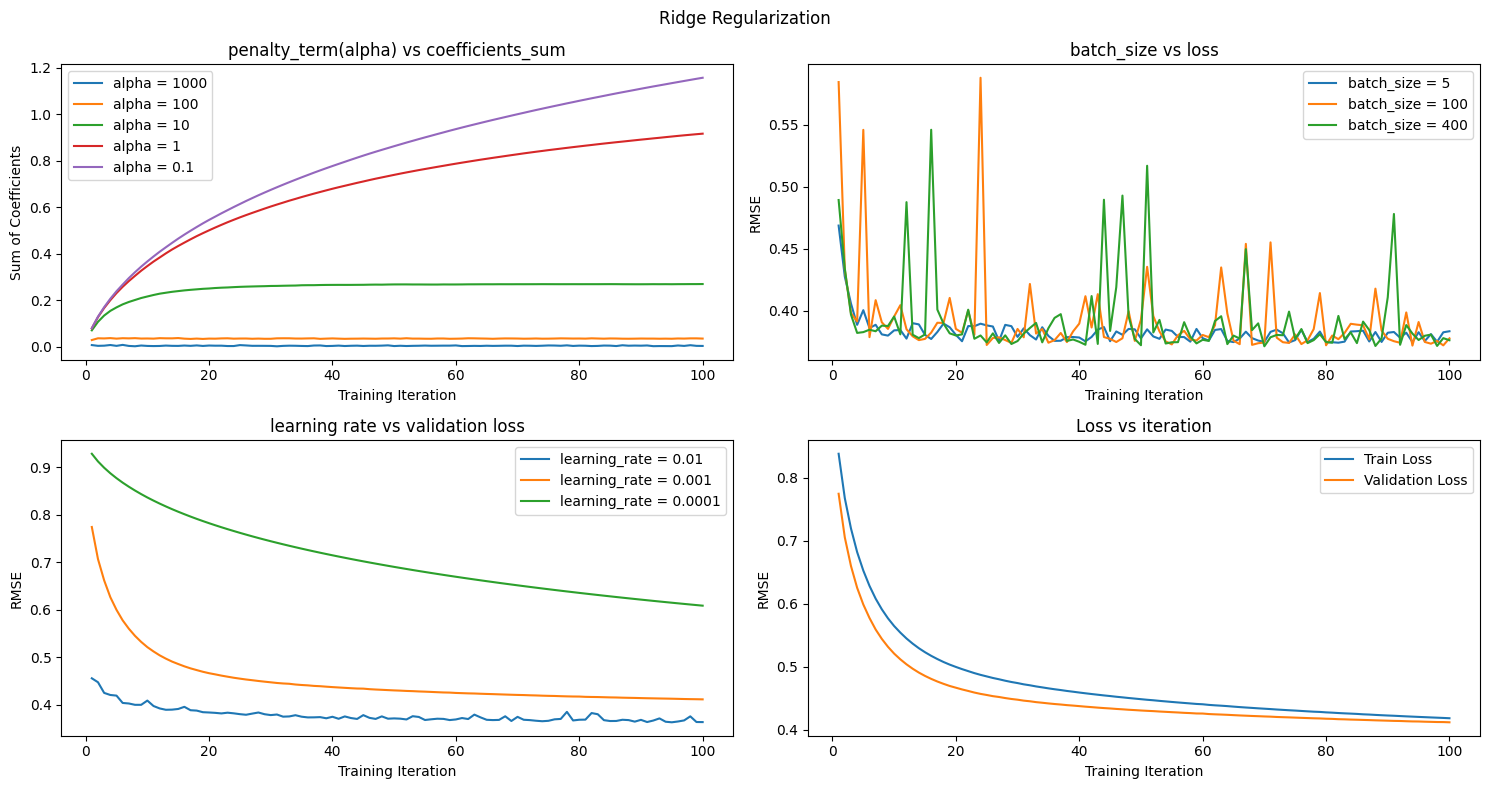

In [38]:
polyRidgeLoss = poly_train_loop('Ridge Regularization')

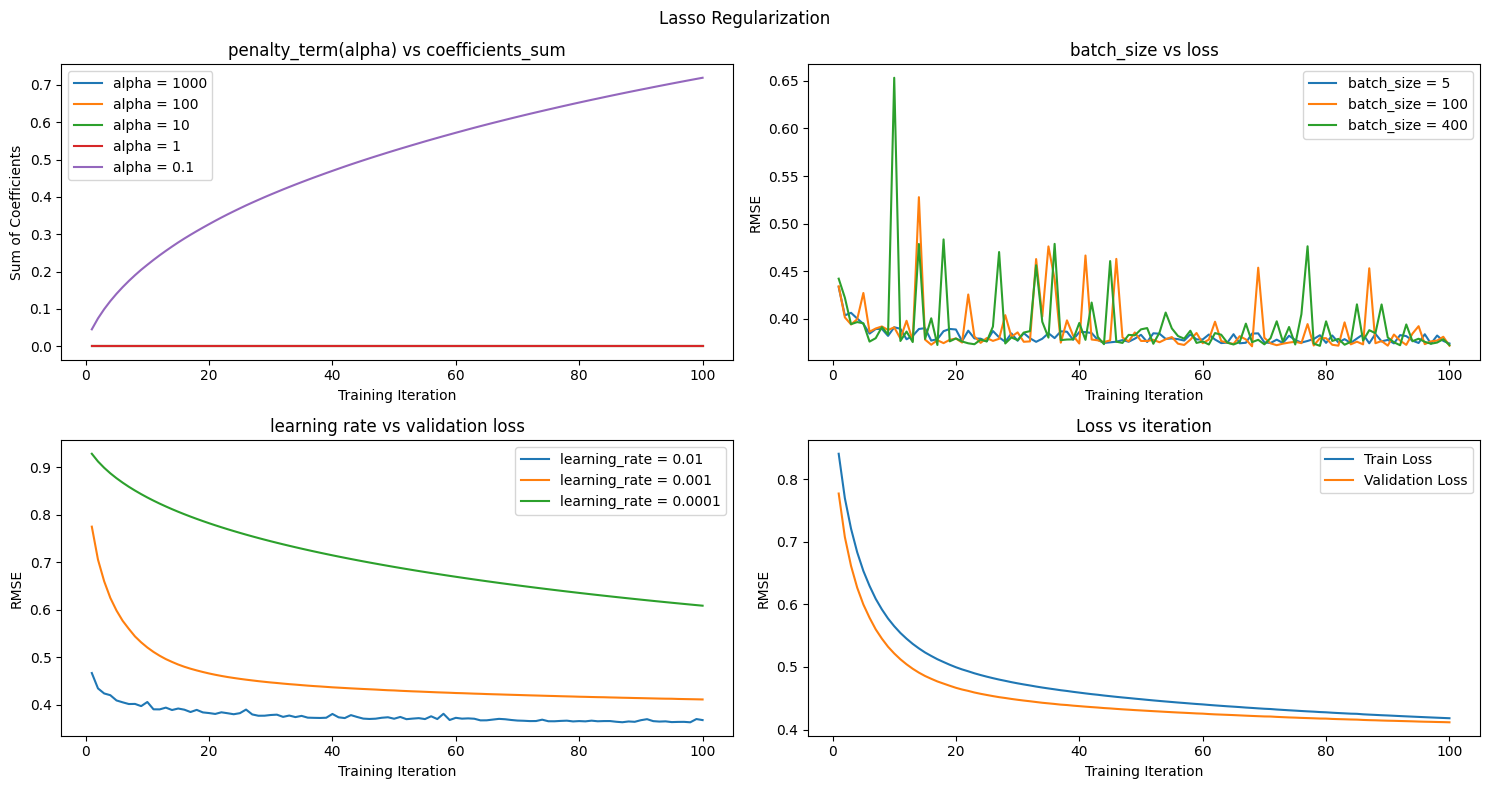

In [39]:
polyLassoLoss = poly_train_loop('Lasso Regularization', penalty='l1')

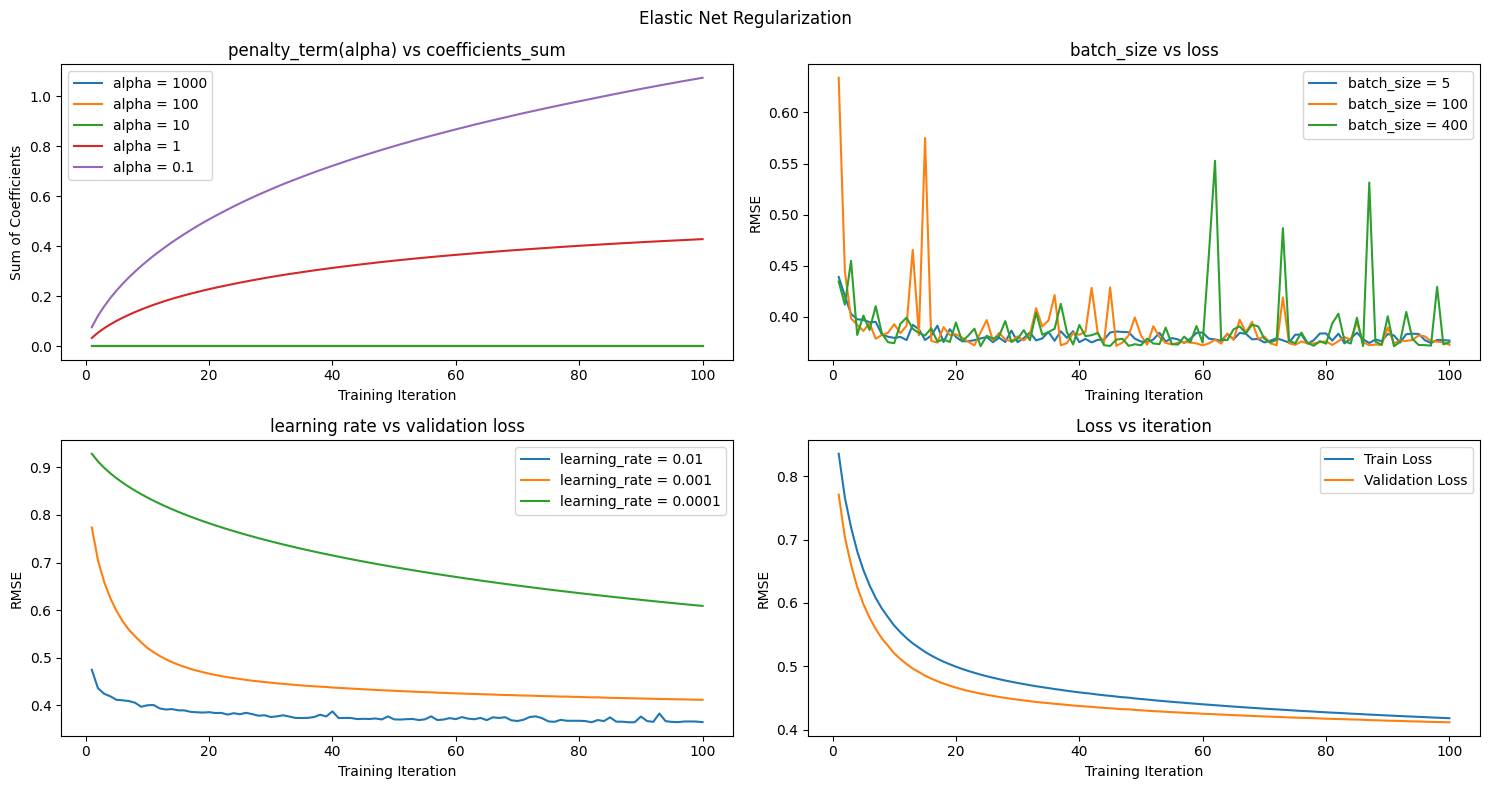

In [40]:
polyElasticNetLoss = poly_train_loop('Elastic Net Regularization', penalty='elasticnet')

#### Observations
- From the "Loss vs iteration" plots(considering the model with proper parameters) of both linear regression and polynomial regression, we can see that the validation loss moves in the same direction as that of training loss for any iteration. 
- For a good model(ignoring the models where we tried different penalty terms, learning rates etc), the validation loss kept decreasing with the decrease in training loss showing that there is no underfitting.
- Also, there is no underfitting as the validation loss curve is below the training loss curve as the model was getting trained.

### Model Evaluation

- For linear regression, we'll use SGDRegressor with eta0 = 0.01 and Ridge regularization.
- For polynomial regression, we'll use SGDRegressor with eta0 = 0.001 and Ridge regularization.
- For both the above models, we'll use the R2_score metric to evaluate model's performance.

In [41]:
# Linear Regression - Training
lin_reg = SGDRegressor(penalty='l2', eta0=0.01)
lin_reg.fit(train_x, train_y)

# Evaluating the model on the test set
test_pred = lin_reg.predict(test_x)
r2_score(test_y, test_pred)

0.6344053147906203

In [42]:
# Linear Regression - Training
poly_reg = SGDRegressor(penalty='l2', eta0=0.001)
poly_reg.fit(train_x_poly, train_y)

# Evaluating the model on the test set
test_pred = poly_lin_reg.predict(test_x_poly)
r2_score(test_y, test_pred)

0.7424200758477929

- From the above R2 scores, we can see that the polynomial regression model performs a little better than the linear regression model as it is able to capture the non-linear relationship between the features and the target.

### Scope of Improvement

- We can furthur improve the efficiency of model by gathering more data to train the model.
- Spend some time in further tuning of hyperparameters like regularization coefficient, learning rate and also try out combining attributes.